# Web Logs Analysis
By Nicholas Cannon

In [1]:
import sqlalchemy as sa
import pandas as pd
import os
import matplotlib.pyplot as plt

%matplotlib inline

DB_URI = os.environ.get('DB_URI') or 'sqlite:///db.sqlite'

## Load Table

In [2]:
engine = sa.create_engine(DB_URI)
df = pd.read_sql_table('logs', engine, index_col='id')
df.head()

,ds,ClientHost,ClientPort,ClientUsername,DownstreamContentSize,DownstreamStatus,Duration,OriginContentSize,OriginDuration,OriginStatus,...,ServiceAddr,ServiceName,ServiceScheme,ServiceUrlPath,ServiceUrlRawPath,ServiceUrlRawQuery,ServiceUrlFragment,entryPointName,level,msg
id,,,,,,,,,,,,,,,,,,,,,
1,2020-02-03,124.187.148.189,51113,-,0,304,5719464,0.0,5675570.0,304.0,...,172.18.0.3:8000,portfolio-api@docker,None,,,,,https,info,
2,2020-02-03,124.187.148.189,51113,-,0,304,13070902,0.0,13044864.0,304.0,...,172.18.0.3:8000,portfolio-api@docker,None,,,,,https,info,
3,2020-02-03,124.187.148.189,51117,-,0,304,4607687,0.0,4551112.0,304.0,...,172.18.0.5:8080,portfolio-web@docker,None,,,,,https,info,
4,2020-02-03,124.187.148.189,51119,-,0,304,16851249,0.0,16778514.0,304.0,...,172.18.0.3:8000,portfolio-api@docker,None,,,,,https,info,
5,2020-02-03,124.187.148.189,51119,-,0,304,17624818,0.0,17553752.0,304.0,...,172.18.0.3:8000,portfolio-api@docker,None,,,,,https,info,


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 51259 entries, 1 to 51259
Data columns (total 31 columns):
ds                       51259 non-null datetime64[ns]
ClientHost               51259 non-null object
ClientPort               51259 non-null object
ClientUsername           51259 non-null object
DownstreamContentSize    51259 non-null int64
DownstreamStatus         51259 non-null int64
Duration                 51259 non-null int64
OriginContentSize        50862 non-null float64
OriginDuration           50862 non-null float64
OriginStatus             50862 non-null float64
Overhead                 51259 non-null int64
RequestAddr              50603 non-null object
RequestContentSize       51259 non-null int64
RequestCount             51259 non-null int64
RequestHost              50603 non-null object
RequestMethod            51259 non-null object
RequestPath              51259 non-null object
RequestPort              50603 non-null object
RequestProtocol          51259 non-null 

## Daily Traffic Analysis

In [4]:
daily_traffic = df.groupby('ds').size()

**Busiest days**

In [5]:
daily_traffic.sort_values(ascending=False).head()

ds
2020-04-02    2070
2020-05-30    1449
2020-02-10    1390
2020-04-24    1280
2020-04-17    1278
dtype: int64

**Mean traffic per day**

In [6]:
daily_traffic.mean()

374.15328467153284

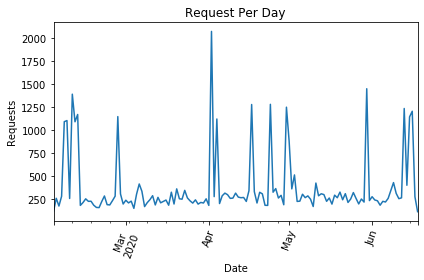

In [7]:
daily_traffic.plot()
plt.title('Request Per Day')
plt.xlabel('Date')
plt.ylabel('Requests')
plt.xticks(rotation=70)
plt.tight_layout()
plt.savefig('plots/requests-per-day')

Some days seem to be hit pretty hard, most likely bots.

## Traefik Router Analysis

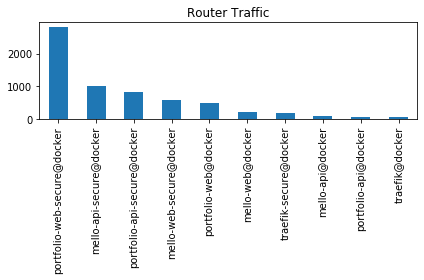

In [8]:
df['RouterName'].value_counts().plot(kind='bar', title='Router Traffic')
plt.tight_layout()
plt.savefig('plots/router-traffic')

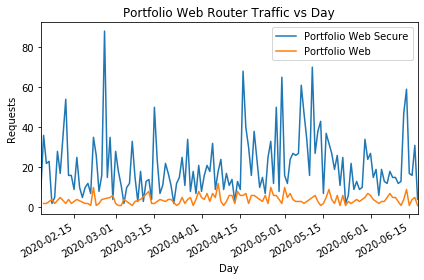

In [9]:
df[df['RouterName'] == 'portfolio-web-secure@docker'].groupby('ds').size().plot(label='Portfolio Web Secure')
df[df['RouterName'] == 'portfolio-web@docker'].groupby('ds').size().plot(label='Portfolio Web')
plt.title('Portfolio Web Router Traffic vs Day')
plt.xlabel('Day')
plt.ylabel('Requests')
plt.legend()
plt.tight_layout()
plt.savefig('plots/web-router-traffic')

Comparison of http vs https traffic over the Portfolio web router. 

## Request Host Analysis

In [10]:
df_host = df.groupby('RequestHost').size().sort_values(ascending=False)

In [11]:
df_host[df_host > 100]

RequestHost
165.22.50.81                     22550
atlantapolaritycenter.com         4596
www.atlantapolaritycenter.com     4148
vip-bitkoin.com                   3953
www.niccannon.com                 3308
intedsin.com                      2703
niccannon.com                     1561
1000bitkoin.com                   1299
www.api.mello.niccannon.com       1109
aningropof.info                    901
www.api.niccannon.com              897
www.mello.niccannon.com            802
mello.niccannon.com                545
api.niccannon.com                  253
monitor.niccannon.com              240
127.0.0.1                          238
www.vip-bitkoin.com                183
ip.ws.126.net                      165
www.intedsin.com                   161
api.mello.niccannon.com            126
www.1000bitkoin.com                111
www.aningropof.info                110
dtype: int64

Seem to be a lot of traffic from spoofed host headers!!

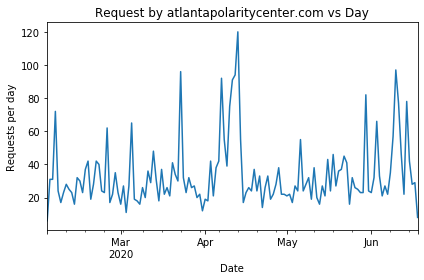

In [12]:
(df[df['RequestHost'] == 'atlantapolaritycenter.com']
    .groupby('ds')
    .size()
    .plot(title='Request by atlantapolaritycenter.com vs Day'))
plt.xlabel('Date')
plt.ylabel('Requests per day')
plt.tight_layout()
plt.savefig('plots/spoofed-host-traffic')

## Request Analysis

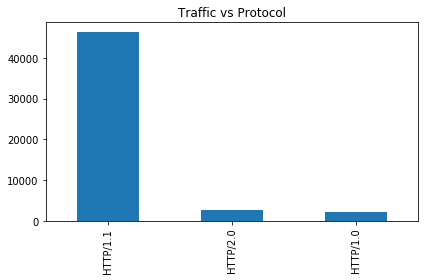

In [13]:
df['RequestProtocol'].value_counts().plot(kind='bar', title='Traffic vs Protocol')
plt.tight_layout()
plt.savefig('plots/traffic-vs-protocol')

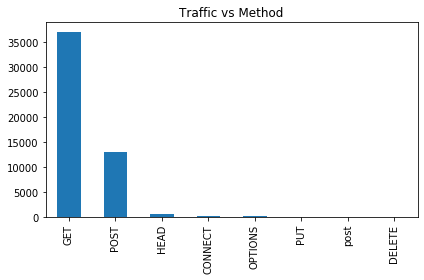

In [14]:
df['RequestMethod'].value_counts().plot(kind='bar', title='Traffic vs Method')
plt.tight_layout()
plt.savefig('plots/traffic-vs-method')

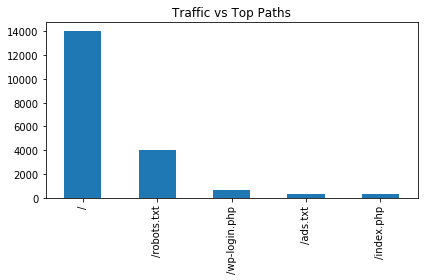

In [15]:
df['RequestPath'].value_counts(sort=True, ascending=False)[:5].plot(kind='bar', title='Traffic vs Top Paths')
plt.tight_layout()
plt.savefig('plots/traffic-vs-top-paths')